# Exercise 1

--> courseutils.py in same folder (great idea for own projects as well!!!)

In [1]:
from nltk.tokenize import sent_tokenize
import string
import re

# tqdm allows you to display progress bars in loops
from tqdm import tqdm
from datetime import datetime

# you need to have courseutils.py in the same folder
from courseutils import get_review_data

import gensim

# lets get more output
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


note that there are some slight syntax changes between gensim 3 and 4; notebook is now optimized for gensim 4.

In [2]:
gensim.__version__

'4.0.1'

## Step 1: Get a lot of texts

I'll just take the movie reviews here, but you are *very much encouraged* to take your own data. Use any method to get them into a long list (or similar).

In [3]:
train, test, _, _ = get_review_data()

Using cached file reviewdata.pickle.bz2


In [4]:
# we just need one list
print(f"The original dataset has two sets of reviews of length {len(train)} and {len(test)}")
train.extend(test)
del test
print(f"We merged them into one list of {len(train)} reviews")

The original dataset has two sets of reviews of length 25000 and 25000
We merged them into one list of 50000 reviews


In [5]:
train[:3]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

## Step 2: Reformat
We want to train on sentences, not on whole reviews. We don't need a list of reviews, but a list of sentences.

Also, **we only want unique sentences**. It has been shown that this improves the resulting models (and it speeds up training, of course).

There are different ways of achieving this, here is one. Some remarks:

- tqdm displays a progress bar - it's not strictly necessary
- a set is like a list without order, and all items are guaranteed to be unique. You could also use a list, but this is faster. Then, you need to use `uniquesentences = []` and `.append()` instead of `.add()`
- we also remove punctuation 
- depending on whether the texts we want to use our model on later on are lowercased or not, we have to (or not) lowercase here as well. That's a decision to make.

In [6]:
trans = str.maketrans('', '', string.punctuation) # translation scheme for removing punctuation
uniquesentences = set()
for review in tqdm(train):
    for sentence in sent_tokenize(review):
        # remove HTML tags in there
        sentence = re.sub(r"<.*?>"," ",sentence)
        sentence = sentence.translate(trans) 
        if sentence not in uniquesentences:
            uniquesentences.add(sentence.lower())

100%|██████████| 50000/50000 [00:22<00:00, 2211.16it/s]


In [7]:
print(f"We now have {len(uniquesentences)} unique sentences.")

We now have 516343 unique sentences.


In [8]:
# if we want to, we can turn the set into a list and expect it, e.g. like this:
# list(uniquesentences)[:10]

**Note that unqiesentences can be also a generator that reads from disk (or from elsewhere) for the next step. Hence, it is possible to train models on more sentences than fit in your memory!**

## Step 3: Train the model

That's really straightforward in gensim

In [9]:
# we do not need a list of lists of tokens later on, so let's use a generator instead of a list to save memory
# note that we use round parentheses instead of square brackets to achieve this
# we do need two generators, though, as we first need to build the vocabulary and later need to train.
# If we use a list, we obviously only need once.
tokenizedsentences = (sentence.split() for sentence in uniquesentences)
tokenizedsentences2 = (sentence.split() for sentence in uniquesentences)

In [10]:
print(f"Started setting up the model at {datetime.now()}")
model = gensim.models.Word2Vec(vector_size=300) # we want 300 dimensions
model.build_vocab(tokenizedsentences)
print(f"Started training at {datetime.now()}")
model.train(tokenizedsentences2, total_examples=model.corpus_count,  epochs=1)
# our model gets better if we use more epochs, but we can only do so if we use a list instead of a generator as input
# after all, you can only pass over a generator once.
# model.train(tokenizedsentences2, total_examples=model.corpus_count,  epochs=model.epochs)
print(f"Finished training at {datetime.now()}")

2021-04-29 15:23:43,826 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-04-29T15:23:43.812167', 'gensim': '4.0.1', 'python': '3.8.5 (default, Jan 27 2021, 15:41:15) \n[GCC 9.3.0]', 'platform': 'Linux-5.4.0-72-generic-x86_64-with-glibc2.29', 'event': 'created'}
2021-04-29 15:23:43,827 : INFO : collecting all words and their counts
2021-04-29 15:23:43,828 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-29 15:23:43,907 : INFO : PROGRESS: at sentence #10000, processed 217843 words, keeping 20608 word types


Started setting up the model at 2021-04-29 15:23:43.810037


2021-04-29 15:23:43,993 : INFO : PROGRESS: at sentence #20000, processed 435503 words, keeping 30088 word types
2021-04-29 15:23:44,072 : INFO : PROGRESS: at sentence #30000, processed 655244 words, keeping 37605 word types
2021-04-29 15:23:44,140 : INFO : PROGRESS: at sentence #40000, processed 875466 words, keeping 43853 word types
2021-04-29 15:23:44,199 : INFO : PROGRESS: at sentence #50000, processed 1092959 words, keeping 49104 word types
2021-04-29 15:23:44,261 : INFO : PROGRESS: at sentence #60000, processed 1309717 words, keeping 53822 word types
2021-04-29 15:23:44,330 : INFO : PROGRESS: at sentence #70000, processed 1526510 words, keeping 58101 word types
2021-04-29 15:23:44,385 : INFO : PROGRESS: at sentence #80000, processed 1744282 words, keeping 62259 word types
2021-04-29 15:23:44,445 : INFO : PROGRESS: at sentence #90000, processed 1961795 words, keeping 66158 word types
2021-04-29 15:23:44,525 : INFO : PROGRESS: at sentence #100000, processed 2178748 words, keeping 69

Started training at 2021-04-29 15:23:48.156283


2021-04-29 15:23:49,170 : INFO : EPOCH 1 - PROGRESS: at 7.33% examples, 613244 words/s, in_qsize 6, out_qsize 0
2021-04-29 15:23:50,178 : INFO : EPOCH 1 - PROGRESS: at 15.43% examples, 640753 words/s, in_qsize 5, out_qsize 0
2021-04-29 15:23:51,199 : INFO : EPOCH 1 - PROGRESS: at 23.69% examples, 652368 words/s, in_qsize 5, out_qsize 1
2021-04-29 15:23:52,220 : INFO : EPOCH 1 - PROGRESS: at 31.28% examples, 645084 words/s, in_qsize 5, out_qsize 0
2021-04-29 15:23:53,235 : INFO : EPOCH 1 - PROGRESS: at 38.74% examples, 638535 words/s, in_qsize 5, out_qsize 0
2021-04-29 15:23:54,239 : INFO : EPOCH 1 - PROGRESS: at 46.59% examples, 641426 words/s, in_qsize 5, out_qsize 0
2021-04-29 15:23:55,249 : INFO : EPOCH 1 - PROGRESS: at 54.57% examples, 643836 words/s, in_qsize 5, out_qsize 0
2021-04-29 15:23:56,266 : INFO : EPOCH 1 - PROGRESS: at 62.62% examples, 646174 words/s, in_qsize 6, out_qsize 0
2021-04-29 15:23:57,275 : INFO : EPOCH 1 - PROGRESS: at 70.63% examples, 648571 words/s, in_qsize

Finished training at 2021-04-29 15:24:00.991890


In [11]:
gensim.models.Word2Vec?

In [12]:
model.save("mymodel")

2021-04-29 15:24:01,064 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'mymodel', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-04-29T15:24:01.064686', 'gensim': '4.0.1', 'python': '3.8.5 (default, Jan 27 2021, 15:41:15) \n[GCC 9.3.0]', 'platform': 'Linux-5.4.0-72-generic-x86_64-with-glibc2.29', 'event': 'saving'}
2021-04-29 15:24:01,066 : INFO : storing np array 'vectors' to mymodel.wv.vectors.npy
2021-04-29 15:24:01,205 : INFO : storing np array 'syn1neg' to mymodel.syn1neg.npy
2021-04-29 15:24:01,341 : INFO : not storing attribute cum_table
2021-04-29 15:24:01,370 : INFO : saved mymodel


In [13]:
# and load it again, just to check
mymodel = gensim.models.Word2Vec.load("mymodel")

2021-04-29 15:24:01,378 : INFO : loading Word2Vec object from mymodel
2021-04-29 15:24:01,400 : INFO : loading wv recursively from mymodel.wv.* with mmap=None
2021-04-29 15:24:01,402 : INFO : loading vectors from mymodel.wv.vectors.npy with mmap=None
2021-04-29 15:24:01,486 : INFO : loading syn1neg from mymodel.syn1neg.npy with mmap=None
2021-04-29 15:24:01,561 : INFO : setting ignored attribute cum_table to None
2021-04-29 15:24:01,907 : INFO : Word2Vec lifecycle event {'fname': 'mymodel', 'datetime': '2021-04-29T15:24:01.907532', 'gensim': '4.0.1', 'python': '3.8.5 (default, Jan 27 2021, 15:41:15) \n[GCC 9.3.0]', 'platform': 'Linux-5.4.0-72-generic-x86_64-with-glibc2.29', 'event': 'loaded'}


# Step 4: Play with the model

In [14]:
animals = ['cat', 'dog', 'horse', 'goldfish', 'lion']
for animal in animals:
    try:
        print(f"A {animal} is almost the same as a {model.wv.most_similar(animal)[0][0]}.")
    except Exception as e:
        print(e)

A cat is almost the same as a horse.
A dog is almost the same as a baby.
A horse is almost the same as a forest.
A goldfish is almost the same as a lizard.
A lion is almost the same as a pioneer.


In [15]:
animals = ['director', 'actor', 'bad', 'good']
for animal in animals:
    try:
        print(f"A {animal} is almost the same as a {model.wv.most_similar(animal)[0][0]}.")
    except Exception as e:
        print(e)

A director is almost the same as a writer.
A actor is almost the same as a actress.
A bad is almost the same as a good.
A good is almost the same as a decent.


In [16]:
model.wv.most_similar("action")

[('suspense', 0.7863096594810486),
 ('gore', 0.76703941822052),
 ('cheesy', 0.7289304137229919),
 ('dramatic', 0.7081713676452637),
 ('slasher', 0.7052612900733948),
 ('atmosphere', 0.7052584886550903),
 ('drama', 0.703515887260437),
 ('exciting', 0.7013792991638184),
 ('standard', 0.700564444065094),
 ('humor', 0.7004095315933228)]

In [17]:
model.wv.most_similar("movie")

[('film', 0.9424377679824829),
 ('show', 0.7994632124900818),
 ('flick', 0.7537067532539368),
 ('sequel', 0.7488694190979004),
 ('documentary', 0.7293484210968018),
 ('picture', 0.7136430740356445),
 ('series', 0.708884060382843),
 ('episode', 0.6871321201324463),
 ('it', 0.6833255887031555),
 ('game', 0.6566664576530457)]

In [27]:
# the classig king/queen example (of course this one doesn't work out on movie-trained embeddings)
model.wv.most_similar(positive=["king", "woman"], negative=["man"])

[('jones', 0.88011234998703),
 ('taylor', 0.8768390417098999),
 ('jr', 0.8748553991317749),
 ('charles', 0.8747254014015198),
 ('l', 0.8740243911743164),
 ('gene', 0.8718414306640625),
 ('julie', 0.8717405200004578),
 ('de', 0.8704596757888794),
 ('prince', 0.8697109818458557),
 ('daniel', 0.8689660429954529)]

# 5 Adapt

Now it's time to dive into the gensim documentation (online or via `?` / tab completion) to figure out the options you have - e.g., skipgram vs CBOW, dimensions, etc.

# Other things we can do

Some things that came up.


## Dictionary expansion

One cool thing that we can do is to expand a list of words with near-synonyms. For instance, imagine we use a simple keyword-based approach to count how often some word we are interested in occurs in a corpus. But maybe we forgot one? In that case, why not expand our list with (near-)synonyms from an embedding model?

In [18]:
# let's get the most similar words to our seed words
seedlist = ['action', 'horror', 'comedy','nature','family','cartoon']
words = seedlist.copy()
for w in seedlist:
    words.extend([e[0] for e in model.wv.most_similar(w)])

print(words)

['action', 'horror', 'comedy', 'nature', 'family', 'cartoon', 'suspense', 'gore', 'cheesy', 'dramatic', 'slasher', 'atmosphere', 'drama', 'exciting', 'standard', 'humor', 'slasher', 'scifi', 'genre', 'classic', 'lowbudget', 'b', 'hollywood', 'disney', 'trash', 'comedy', 'thriller', 'drama', 'flick', 'genre', 'entertainment', 'romantic', 'documentary', 'horror', 'masterpiece', 'filmmaking', 'depiction', 'essence', 'beauty', 'context', 'moral', 'terms', 'spirit', 'social', 'narrative', 'strength', 'country', 'dream', 'business', 'relationship', 'dreams', 'soul', 'life', 'child', 'lives', 'friendship', 'miniseries', 'entry', 'sitcom', '1950s', 'milestone', 'era', 'western', '70s', 'segment', 'comedydrama']


In [19]:
[e[0] for e in model.wv.most_similar("action")]

['suspense',
 'gore',
 'cheesy',
 'dramatic',
 'slasher',
 'atmosphere',
 'drama',
 'exciting',
 'standard',
 'humor']

## Plotting

We can also use a method called tsne (from our good friend scikit-learn) to make a two-dimensional projection of our 300-dimensional embeddings to plot the distances of the words (not the most interesting data here, but you get the idea):

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [21]:
def plot_words(words, model):
    '''takes a list of words and a word embedding model as input and plots the words
    in a 2-dimensional projection of the space'''
    # make sure words are unique:
    words = set(words)
    X = model.wv[words]
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
    for w, pos in zip(words,X_tsne):
        ax.annotate(w, pos)

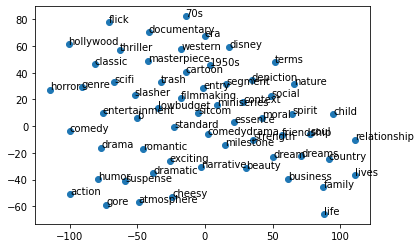

In [22]:
plot_words(words, model)
